## Change Log (v.2.5)
- It supports now form-based, i.e. character-level.
- zero-mask, get_dummies now drop_first
- final outputs needs masking. need to invistegated weighted sample

# 1. Import

In [513]:
# -*- coding: utf-8 -*-
'''
    An implementation of sequence to sequence learning
    for performing ensemble morphosyntactic analyses
'''
from __future__ import print_function
# from keras.preprocessing.sequence import pad_sequences
import numpy as np
from six.moves import range
from prepare_data import SawarefData, padIndexes
from character_table import colors, CharacterTable, eprint
import pandas as pd
import itertools
import re
import pickle
import sys
import datetime
from keras.callbacks import TensorBoard
from buckwalter import utf2bw, bw2utf
from pprint import pprint

# do not import in interactive mode
# from vis import SawarefVis
from keras.models import Sequential, Model, load_model
from keras import layers
from keras.callbacks import EarlyStopping, Callback
from keras.utils import plot_model

np.random.seed(0)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
sys.executable

# 2. Constants

In [654]:
MYPATH = "/morpho/output/"
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
EPOCHS = 40
EMBEDDINGS = 0
# DIGITS = 3
# REVERSE = True
# Try replacing GRU, or SimpleRNN.
HIDDEN_SIZE = 128
BATCH_SIZE = 64
LAYERS = 1
ITERATIONS = 10
REVERSE = False
MODEL_NAME = "main-seq-multiinput-multioutput-segmentation.keras"
DATA_PICKLE = "main-seq-multiinput-multioutput-segmentation.pickle"
RNN = layers.LSTM
CATS_EMBEDDING = 1000
TEST_SPLIT = 1  #  means 0.1 of data is for test
VAL_SPLIT = 1  #  means 0.1 of data is for test
LOAD_FASTTEXT = False
CHARACTER_BASED = False
MORPHEME_BASED = False

previous_names = set()

In [516]:
if LOAD_FASTTEXT:
    from gensim.models import FastText
    emb = FastText.load_fasttext_format("/Users/abbander/Leeds/OpenArabic/data/classical.bin")

In [655]:
def set_name():
    global NAME, thedate, previous_names
    NAME = input("What is the name of this experiment? ")
    print("\nNAME=", NAME)
    thedate = datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M")
    previous_names.add(NAME+"%"+thedate)

set_name()

What is the name of this experiment? test

NAME= test


# 3. Config

`feat_x` is the input categorical features

`feat_y` is the output categorical features

`strings_x` is the input character-based strings features

`strings_y` is the output character-based strings features

In [4]:
tools = ["MX", "FA", "AM", "ST"]
import itertools

for L in range(1, len(tools)):
    for subset in itertools.combinations(tools, L):
        print(subset)


('MX',)
('FA',)
('AM',)
('ST',)
('MX', 'FA')
('MX', 'AM')
('MX', 'ST')
('FA', 'AM')
('FA', 'ST')
('AM', 'ST')
('MX', 'FA', 'AM')
('MX', 'FA', 'ST')
('MX', 'AM', 'ST')
('FA', 'AM', 'ST')


In [729]:
feat_x = [
    "MXpos", "STpos", "AMpos", "FApos", "STaspect", "AMaspect", "MXaspect",
    "FAaspect", "STperson", "AMperson", "MXperson", "FAperson", "STgender",
    "AMgender", "MXgender", "FAgender", "STnumber", "AMnumber", "MXnumber",
    "FAnumber", "STcase", "AMcase", "MXcase", "FAcase", "STvoice", "AMvoice",
    "MXvoice", "FAvoice", "STmood", "AMmood", "MXmood", "FAmood", "STstate",
    "AMstate", "MXstate", "FAstate"
]
feat_y = [
    "QApos", "QAaspect", "QAperson", "QAgender", "QAnumber", "QAcase",
    "QAvoice", "QAmood", "QAstate"
]
strings_x = ["QAwutf8", "word"]
strings_y = ["QAutf8"]
if CHARACTER_BASED:
    strings_x = ["bw"]
elif MORPHEME_BASED:
    strings_x = []

In [521]:
def pretty_join(arr):
    if isinstance(arr, pd.Series):
        arr = arr.to_frame().T
    if isinstance(arr.columns, pd.core.index.MultiIndex):
        return "/".join([
            '+'.join([
                x[1] for x in arr.columns[row == 1]
                if x[1][-2:] != "na" and x[1][-2:] != "_0"
            ]) for index, row in arr.iterrows()
        ])
    else:
        return "/".join([
            '+'.join([
                x for x in arr.columns[row == 1]
                if x[-2:] != "na" and x[-2:] != "_0"
            ]) for index, row in arr.iterrows()
        ])


def pretty_value(colum_value):
    return re.sub(".*_", "", colum_value)


def getValuesAndReshape(df, middle_dim):
    return df.values.reshape((df.shape[0] // middle_dim, middle_dim, -1))


#     return df.values.reshape((df.shape[0]//middle_dim, middle_dim, df.shape[1]))


def flattencolumns(df1, cols):
    df = pd.concat(
        [pd.DataFrame(df1[x].values.tolist()).add_prefix(x) for x in cols],
        axis=1)
    return pd.concat([df, df1.drop(cols, axis=1)], axis=1)


def truncate(x):
    return x[:EMBEDDINGS]


def removeDiac(x):
    return re.sub('[ًٌٍَُِّْ��]', '', x.replace("ٱ","ا"))


def padStringWithSpaces(x):
    return x + ' ' * (STRING_LENGTH - len(x))


def joinMorphemesStrings(arr):
    return "+".join([
        x for x in arr if isinstance(x, float) == False and x != -1
        and x != "-----" and x != "-"
    ])


def fullprint(*args, **kwargs):
    opt = np.get_printoptions()
    np.set_printoptions(threshold='nan')
    pprint(*args, **kwargs)
    np.set_printoptions(**opt)
    

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        metrics = self.model.evaluate(x, y, verbose=0)
        for i,x in enumerate(self.model.metrics_names):
            logs["test_"+x]= metrics[i]
        logs['test_acc']= np.mean([logs["test_"+x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        logs['val_acc']= np.mean([logs["val_"+x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        logs['train_acc']= np.mean([logs[x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        return logs


# 4. Loading data from sawaref

In [678]:
sawarefData = SawarefData(
    MYPATH,
    EMBEDDINGS,
    align_type="",
    feat_x=feat_x,
    strings_x=strings_x,
    strings_y=strings_y,
    feat_y=feat_y)

Reading from file: morpho.output..pickle
1111
Vectorization...


In [679]:
source = list(itertools.chain(*sawarefData.quran_sent))
df = pd.DataFrame(
    source,
    columns=["sid", "aid", "wid", "mid"] + feat_x + strings_x + strings_y +
    ["embeddings"] + feat_y)
if EMBEDDINGS > 0:
    df["embeddings"] = df["embeddings"].apply(truncate)
    df = flattencolumns(df, ["embeddings"])
df.set_index(["sid", "aid", "wid", "mid"], inplace=True)
df.sort_index(inplace=True)

In [680]:
strings = strings_x + strings_y

# a. clean all padded rows
for s in strings:
    #df.loc[df2[("vals", s)] == -1, ("vals", s)] = -1
    df.loc[pd.isna(df[s]), s] = ""

for x in strings:
    df[x+"_undiac"] = df[x].apply(removeDiac)

In [681]:
## 2. Pad the rows according to the longest word (in # of morphemes)
SENTLEN = max(df.index.get_level_values("mid"))
df = df.reindex(
    padIndexes(df, max(df.index.get_level_values("mid"))),
    fill_value=-1).sort_index()

In [682]:
## 3. Get the hot encoding of all caterogirical data (see columns attr)
dumm = pd.get_dummies(df, columns=feat_x + feat_y)

In [685]:
for x in feat_x:
    dumm.drop(x+"_-1",axis=1,inplace=True)

In [695]:
# some data needs cleaning (TODO later: investigate source, fix)
dumm[dumm["QApos_0"]==1].filter(regex="(QAutf8|QApos_.*)")

QAutf8 QAutf8_undiac  QApos_-1  QApos_0  QApos_ACC  \
sid    aid wid mid                                                      
fourty 11  111 2                                0        1          0   
           113 2                                0        1          0   
               3                                0        1          0   
           120 2                                0        1          0   
       21  2   2                                0        1          0   
           3   2                                0        1          0   
           10  2                                0        1          0   
           52  3                                0        1          0   
           64  3                                0        1          0   
           80  3                                0        1          0   
           91  3                                0        1          0   
       43  2   2                                0        1          0   
           4   2                                0        1          0   
           7   2                                0        1          0   
           30  3                                0        1          0   
           37  3                                0        1          0   
       82  4   2                                0        1          0   
           9   3                                0        1          0   
       89  4   2                                0        1          0   
       123 4   4                                0        1          0   
           7   2                                0        1          0   
       139 21  2                                0        1          0   
           44  2                                0        1          0   
           217 2                                0        1          0   
           257 3                                0        1          0   
       152 4   2                                0        1          0   
           154 2                                0        1          0   
           155 3                                0        1          0   
       222 4   4                                0        1          0   
           7   2                                0        1          0   
...                   ...           ...       ...      ...        ...   
q75    25  5   3                                0        1          0   
       26  3   2                                0        1          0   
       29  1   3                                0        1          0   
       37  3   2                                0        1          0   
           5   2                                0        1          0   
       38  3   2                                0        1          0   
       39  3   3                                0        1          0   
q90    3   3   2                                0        1          0   
               3                                0        1          0   
       4   5   2                                0        1          0   
       6   3   2                                0        1          0   
           4   2                                0        1          0   
       8   4   2                                0        1          0   
       9   1   3                                0        1          0   
           2   3                                0        1          0   
       10  2   3                                0        1          0   
       11  3   3                                0        1          0   
       12  4   3                                0        1          0   
       13  1   2                                0        1          0   
           2   2                                0        1          0   
       14  6   2                                0        1          0   
       15  1   2                                0        1          0   
    

In [704]:
dumm.filter(regex=".*aspect.*")

AMaspect_0  AMaspect_IMPF  AMaspect_IMPV  AMaspect_PERF  \
sid    aid wid mid                                                            
fourty 11  1   1           1.0            0.0            0.0            0.0   
               2           1.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           2   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           3   1           1.0            0.0            0.0            0.0   
               2           1.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           4   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           5   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           6   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
...                        ...            ...            ...            ...   
q90    19  4   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           5   1           1.0            0.0            0.0            0.0   
               2           0.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
           6   1           1.0            0.0            0.0            0.0   
               2           1.0            0.0            0.0            0.0   
               3           1.0            0.0            0.0            0.0   
               4           0.0            0.0            0.0            0.0   
               5           0.0            0.0            0.0            0.0   
       20  1   1           1.0            0.0            0.0            0.0   
               2           1.0            0.0            0.0            0.0   
               3           0.0            0.0            0.0          

In [698]:
dumm.drop("embeddings", axis=1, inplace=True)

In [699]:
dumm[(dumm.isin([0,-1])).all(axis=1)] = -1.

In [705]:
## 4. Add two-level columns for easy indexing later (wid, mid)
EXAMPLES_LEN = df.shape[0] // SENTLEN
new_columns = []
for x in dumm.columns:
    new_columns.append(re.sub('(_.*|[0-9]*)', '', x))
dumm.columns = [new_columns, dumm.columns]
dumm.index = [[x for x in range(EXAMPLES_LEN) for _ in range(SENTLEN)],
              [x for _ in range(EXAMPLES_LEN) for x in range(SENTLEN)]]
dumm.sort_index(axis=1, inplace=True)

In [706]:
## 5. Find possible values of each cat
def getSet(df):
    results = set()
    df.apply(results.add)
    return results


embeddingInputSets = {i: getSet(df[i]) for i in feat_x}

In [ ]:
embeddingInputSets

In [730]:
feat_x = list(set(feat_x) - set([x for x in feat_x if len( embeddingInputSets[x])<=1]))

In [708]:
df2 = pd.concat([df.reset_index(), dumm.reset_index()], axis=1)
# df2.set_index(["sid", "aid", "wid", "mid"], inplace=True)
df2.index = [[x for x in range(EXAMPLES_LEN) for _ in range(SENTLEN)],
             [x for _ in range(EXAMPLES_LEN) for x in range(SENTLEN)]]

df2.drop(['embeddings' + str(x) for x in range(EMBEDDINGS)], inplace=True, axis=1)
# df2.columns = [(x,"val") if isinstance(x,str) else x  for x in df2.columns]

In [710]:
df2.index = [[x for x in range(EXAMPLES_LEN) for _ in range(SENTLEN)],
             [x for _ in range(EXAMPLES_LEN) for x in range(SENTLEN)]]

In [711]:
df2.columns = [["vals" if isinstance(x, str) else x[0] for x in df2.columns],
               [x if isinstance(x, str) else x[1] for x in df2.columns]]

df2.sort_index(axis=1, inplace=True)

In [588]:
del df
del dumm

In [589]:
## 5. Prepare string columns:
# a. clean all padded rows
for s in strings:
    #         print(df2[s])
    df2.loc[df2[("vals", s)] == -1, ("vals", s)] = -1
    df2.loc[pd.isna(df2[("vals", s)]), ("vals", s)] = -1


In [ ]:
df2["vals", "QAutf8"].groupby(level=[0]).apply(joinMorphemesStrings).head()

In [728]:
def emb_encode(x):
    return np.zeros(emb.vector_size) if x=="" or x == -1 else emb[x]
def convertStringToFeatX(x):
    df2[(x,"emb")] = df2[(x,x+"_undiac")].apply(emb_encode)
    return df2.join(pd.DataFrame(np.stack(df2[(x,"emb")].values),
                         index=df2.index, 
                         columns=[[x+"_emb" for i in range(emb.vector_size)],
                                  [x+"_emb_"+str(i) for i in range(emb.vector_size)]]))

if not CHARACTER_BASED and MORPHEME_BASED:
    df2 = convertStringToFeatX("word")
    feat_x.append("word_emb")

In [714]:
# b. group them by morpheme and join with "+""
df_strings = pd.DataFrame({
    x: df2["vals", x].groupby(level=[0]).apply(joinMorphemesStrings)
    for x in strings
})

In [ ]:
df_strings

In [715]:
# c. pad joined morphemes
STRING_LENGTH = max([len(x) for k in strings for x in df_strings[k]])
for s in strings:
    df_strings[s] = df_strings[s].apply(padStringWithSpaces)

In [716]:
# d. encode them in one hot encoding
charset = set("+").union(
    *[list(set("".join(df_strings[x] + "-"))) for x in strings])
ctable = CharacterTable(charset, STRING_LENGTH)
### Now we have one shape for all strings: (STRING_LENGTH, len(charset))
for x in strings:
    df_strings[x + "_onehot"] = df_strings[x].apply(ctable.encode)
df_strings['num'] = [x for x in range(len(df_strings))]
df_strings.set_index('num', append=True, inplace=True)

In [717]:
# e. remove diac
for x in strings:
    df_strings[x+ "_undiac"] = df_strings[x].apply(removeDiac)

In [718]:
# f. encode them as dense vector using fastText
for x in strings:
    if LOAD_FASTTEXT:
        df_strings[x + "_emb"] = df_strings[x+"_undiac"].apply(emb_encode)

In [115]:
if LOAD_FASTTEXT:
    print(df_strings["QAutf8_emb"][1])
    print(df_strings[1:5])

num
1    [0.096773185, 0.30373535, -0.058814764, -0.672...
Name: QAutf8_emb, dtype: object
                          QAutf8                    QAwutf8  \
  num                                                         
1 1    تِلْكَ                     تِلْكَ                      
2 2    آيَاْتُ                    ءَايَٰتُ                    
3 3    الْ+كِتَاْبِ               ٱلْكِتَٰبِ                  
4 4    الْ+حَكِيمِ                ٱلْحَكِيمِ                  

                            word  \
  num                              
1 1    تِلْكَ                      
2 2    آياتِ                       
3 3    ال+كِتابِ                   
4 4    ال+حَكِيم                   

                                          QAwutf8_onehot  \
  num                                                      
1 1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2 2    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
3 3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4 4    [[0.0,

# 5. Save (or load) the data

In [ ]:
pickle.dump([df2, df_strings], open(DATA_PICKLE, mode="wb"))

In [ ]:
arr = pickle.load(open(DATA_PICKLE, mode="rb"), encoding="UTF8")
(dumm, df_strings) = arr[0], arr[1]
SENTLEN = max(dumm.index.get_level_values(1)) + 1
EXAMPLES_LEN = dumm.shape[0] // SENTLEN

# 6. Prepare splits

In [719]:
# 6. Shuffle (x, y) in unison
indices = list(range(EXAMPLES_LEN))
np.random.shuffle(indices)

In [ ]:
indices

In [720]:
# 7. Explicitly set apart 10% for validation data that we never train over.
test_split_at = int(EXAMPLES_LEN * TEST_SPLIT / 10)
val_split_at = int(EXAMPLES_LEN * TEST_SPLIT / 10 +
                   EXAMPLES_LEN * VAL_SPLIT / 10)


In [ ]:
print(EXAMPLES_LEN, val_split_at, test_split_at)

In [721]:
def getMorphemeBasedIndeicies(arr):
    return np.array([list(range(x*SENTLEN,x*SENTLEN+SENTLEN)) for x in arr]).flatten()

In [ ]:
getMorphemeBasedIndeicies(indices[:test_split_at])

In [722]:
values_test = df_strings.iloc[indices[:test_split_at]]
values_val = df_strings.iloc[indices[test_split_at:val_split_at]]
values_train = df_strings.iloc[indices[val_split_at:]]

test = df2.iloc[getMorphemeBasedIndeicies(indices[:test_split_at])]
val = df2.iloc[getMorphemeBasedIndeicies(indices[test_split_at:val_split_at])]
train = df2.iloc[getMorphemeBasedIndeicies(indices[val_split_at:])]

In [ ]:
train["embeddings"]

In [ ]:
rand=np.random.randint(0,len(values_val))
print(rand, values_test.iloc[rand])
test["QApos"].iloc[rand*5:rand*5+5].idxmax(axis=1)


In [400]:
print(values_test.shape, values_val.shape, values_train.shape)
print(test.shape, val.shape, train.shape)
print(test.shape[0]//5)

(1432, 12) (1433, 12) (11460, 12)
(7160, 691) (7165, 691) (57300, 691)
1432


In [ ]:
TEST = np.random.randint(0, len(values_train.index))
print(TEST)
print(values_train.loc[values_train.index[TEST], ["QAutf8"]])
print(train.loc[train.index[TEST], "QAutf8"])

# TEST = np.random.randint(0, len(train.index))
# TEST = train.index[TEST]
# print(values_train.loc[TEST,["QAutf8"]])

# train.loc[TEST,:]

# arr = train.loc[TEST,:]
# arr.to_frame().T
# arr.index[arr == 1]
pretty_join(train.loc[train.index[TEST], :])

In [ ]:
len(values_train) * 5, len(train)

In [723]:
embeddingInputLists = {
    i: [i + "_" + str(x) for x in embeddingInputSets[i]]
    for i in embeddingInputSets
}

In [724]:
def getValuesAndReshape(df, middle_dim, test=""):
    return df.values.reshape((df.shape[0] // middle_dim, middle_dim, -1))

def setZero(df,zeros, from_val=-1, to_val=0.):
#     dumm[(dumm.isin([0,-1])).all(axis=1)] = -1.
    if zeros:
        df[(df==from_val).all(axis=1)] = to_val
    return df

def getData(cat_source, str_source, cats_feats=[], strs_feats=[], embeddings=False, zeros= False):
    data = {
        **{i:
           getValuesAndReshape(cat_source[i].idxmax(axis=1).apply(lambda x: embeddingInputLists[i].index(x)),SENTLEN)
               if i in embeddingInputSets and len(embeddingInputSets[i]) > 10000+CATS_EMBEDDING #and i.replace("_emb","") not in strings_x
               else getValuesAndReshape(cat_source[i], SENTLEN,i) 
           for i in cats_feats},
        **{i:np.stack(str_source[i+"_onehot"].values) for i in strs_feats},
    }
    if embeddings:
        for i in strs_feats:
            if i+"_emb" not in data:
                data[i+"_emb"] = np.stack(str_source[i+"_emb"].values)
    if zeros:
        for i in cats_feats:
            data[i][np.where(data[i]==-1.)] = 0.
    return data

data = {
    'input': getData(train, values_train, cats_feats=feat_x, strs_feats=strings_x, embeddings=LOAD_FASTTEXT),
    'output': getData(train, values_train, cats_feats=feat_y, strs_feats=strings_y, zeros=True),
    'val': (
        getData(val, values_val, cats_feats=feat_x, strs_feats=strings_x, embeddings=LOAD_FASTTEXT),
        getData(val, values_val, cats_feats=feat_y, strs_feats=strings_y, zeros=True)
    ),
    'test': (
        getData(test, values_test, cats_feats=feat_x, strs_feats=strings_x, embeddings=LOAD_FASTTEXT),
        getData(test, values_test, cats_feats=feat_y, strs_feats=strings_y, zeros=True)
    )

}

In [725]:
data["output"]["QApos"].argmax(axis=-1)

array([[14,  3,  0,  0,  0],
       [14, 29,  0,  0,  0],
       [38,  0,  0,  0,  0],
       ...,
       [32, 14, 29,  1,  0],
       [48,  0,  0,  0,  0],
       [14, 29,  1,  0,  0]])

In [ ]:
data["input"]["QAwutf8_emb"].shape

In [ ]:
# 8. Some info about shapes
print('\nTraining Data:')
print("\n".join(["X: "+i+str(data["input"][i].shape) for i in feat_x]))
print("\n".join(["Y: "+i+str(data["output"][i].shape) for i in feat_y]))
print('\nValidation Data:')
print("\n".join(["X: "+i+str(data["val"][0][i].shape) for i in feat_x]))
print("\n".join(["Y: "+i+str(data["val"][1][i].shape) for i in feat_y]))
print('\nTest Data:')
print("\n".join(["X: "+i+str(data["test"][0][i].shape) for i in feat_x]))
print("\n".join(["Y: "+i+str(data["test"][1][i].shape) for i in feat_y]))




# 7. Load Previous model

In [ ]:
model = load_model(MODEL_NAME)


# 8. Build Model

## 8.1 End-To-End

In [731]:
# print('Build model...')
outputs = []
inputs = []
# For strings
strings_input = layers.Input(shape=(STRING_LENGTH, len(charset)), name=strings_x[0])
lstm_strings_encoder = layers.Bidirectional(RNN(HIDDEN_SIZE,name="lstm_strings_encoder"))(strings_input)

# For categoricals
for i in feat_x:
    inputs.append(layers.Input(shape=(SENTLEN, data["input"][i].shape[2]), name=i))

def getEmbedding(input):
    name = input.name.split("_")[0]
    if name in feat_x and len(embeddingInputSets[name]) > CATS_EMBEDDING:
        return layers.Masking(mask_value=0.)(layers.Reshape((SENTLEN, -1))(layers.Embedding(len(embeddingInputSets[name]),2, input_length=SENTLEN)(input)))
    else:
        return layers.Dropout(0.1)(layers.Masking(mask_value=0.)(input))
    
# main_input = layers.Concatenate()([layers.Dropout(0.1)(input) for input in inputs])
main_input = layers.Concatenate()([getEmbedding(input) for input in inputs])
inputs.append(strings_input)

lstm_out = layers.Bidirectional(RNN(HIDDEN_SIZE))(main_input)
# input_shape=(None, len(ctable_x.chars) + EMBEDDINGS)))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
if LOAD_FASTTEXT:
    emb_input = layers.Input(shape=(emb.vector_size,), name=strings_x[0]+"_emb")
    inputs.append(emb_input)
    concatenated = layers.Concatenate()([lstm_strings_encoder,lstm_out,emb_input])
else:
    concatenated = layers.Concatenate()([lstm_strings_encoder,lstm_out])

# For strings again
repeat_strings_out = layers.RepeatVector(STRING_LENGTH)(concatenated)
rnn_out = RNN(HIDDEN_SIZE, return_sequences=True)(repeat_strings_out)
strings_output = layers.TimeDistributed(
      layers.Dense(
        len(charset), 
        activation="softmax"), name=strings_y[0])(rnn_out)
outputs.append(strings_output)

dropout_out = layers.Dropout(0.5)(concatenated)
repeat_out = layers.RepeatVector(SENTLEN)(dropout_out)
# The decoder RNN could be multiple layers stacked or a single layer.
rnn_out = RNN(HIDDEN_SIZE, return_sequences=True)(repeat_out)
for _ in range(LAYERS-1):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    rnn_out = RNN(HIDDEN_SIZE, return_sequences=True)(rnn_out)

    

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.

for i in feat_y:
    outputs.append(
      layers.TimeDistributed(
      layers.Dense(
        data["output"][i].shape[2], 
        activation="softmax"), name=i)(rnn_out))

## 8.2 Morpheme-Based 

In [502]:
# print('Build model...')
outputs = []
inputs = []

# For categoricals
for i in feat_x:
    inputs.append(layers.Input(shape=(SENTLEN, data["input"][i].shape[2]), name=i))

def getEmbedding(input):
    name = input.name.split("_")[0]
    if name in feat_x and len(embeddingInputSets[name]) > CATS_EMBEDDING:
        return layers.Masking(mask_value=0.)(layers.Reshape((SENTLEN, -1))(layers.Embedding(len(embeddingInputSets[name]),2, input_length=SENTLEN)(input)))
    else:
        return layers.Dropout(0.1)(layers.Masking(mask_value=0.)(input))
    
main_input = layers.Concatenate()([getEmbedding(input) for input in inputs])

lstm_out = layers.Bidirectional(RNN(HIDDEN_SIZE, return_sequences=True))(main_input)


rnn_out = lstm_out

    

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.

for i in feat_y:
    outputs.append(
      layers.TimeDistributed(
      layers.Dense(
        data["output"][i].shape[2], 
        activation="softmax"), name=i)(rnn_out))

## 8.3 Character-Based 

In [505]:
# print('Build model...')
outputs = []
inputs = []

# For categoricals
for i in feat_x:
    inputs.append(layers.Input(shape=(SENTLEN, data["input"][i].shape[2]), name=i))

def getEmbedding(input):
    name = input.name.split("_")[0]
    if name in feat_x and len(embeddingInputSets[name]) > CATS_EMBEDDING:
        return layers.Masking(mask_value=-1.)(layers.Reshape((SENTLEN, -1))(layers.Embedding(len(embeddingInputSets[name]),2, input_length=SENTLEN)(input)))
    else:
        return layers.Dropout(0.1)(layers.Masking(mask_value=-1.)(input))
    
main_input = layers.Concatenate()([getEmbedding(input) for input in inputs])

lstm_out = layers.Bidirectional(RNN(HIDDEN_SIZE, return_sequences=True))(main_input)

rnn_out = lstm_out

    

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.

for i in feat_y:
    outputs.append(
      layers.TimeDistributed(
      layers.Dense(
        data["output"][i].shape[2], 
        activation="softmax"), name=i)(rnn_out))

## Compile

In [732]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
print(inputs,outputs)

# 9. Summary

In [508]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AMnumber (InputLayer)           (None, 5, 1)         0                                            
__________________________________________________________________________________________________
AMaspect (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
MXgender (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
FAvoice (InputLayer)            (None, 5, 1)         0                                            
__________________________________________________________________________________________________
MXaspect (

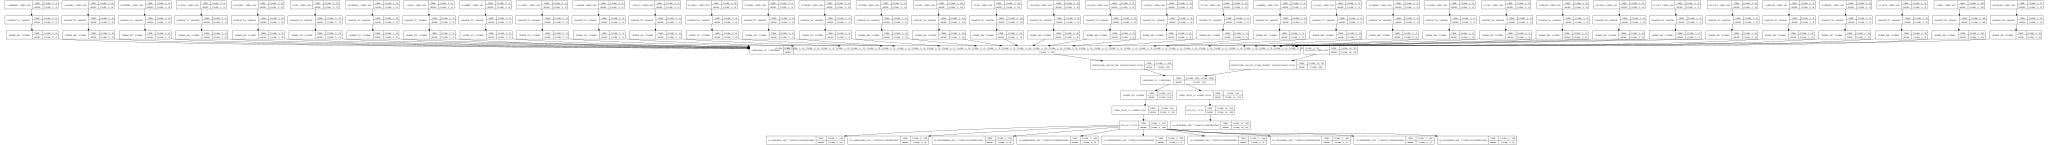

In [733]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
plot_model(model, to_file='model_only_emb.png', show_shapes=True)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# 10. Training

In [734]:
# optional
set_name()

What is the name of this experiment? EndToEnd3

NAME= EndToEnd3


In [735]:
earlyStopping=EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

tensorboard = TensorBoard(
    log_dir="logs/" + NAME + "_{}".format(thedate))


In [736]:
print(NAME + "_{}".format(thedate))
history = model.fit(data['input'], data['output'],
                    batch_size=BATCH_SIZE,
                    callbacks=[earlyStopping, TestCallback(data['test']), tensorboard],
                    epochs=100,
                    verbose=2,
                    validation_data=data['val'])

EndToEnd3_.2018.07.24.15.03
Train on 18056 samples, validate on 2257 samples
Epoch 1/100
 - 56s - loss: 4.3869 - QAutf8_loss: 1.1527 - QApos_loss: 0.8373 - QAaspect_loss: 0.2476 - QAperson_loss: 0.3318 - QAgender_loss: 0.3695 - QAnumber_loss: 0.3846 - QAcase_loss: 0.3539 - QAvoice_loss: 0.2102 - QAmood_loss: 0.2047 - QAstate_loss: 0.2946 - QAutf8_acc: 0.7203 - QApos_acc: 0.7933 - QAaspect_acc: 0.9217 - QAperson_acc: 0.8949 - QAgender_acc: 0.8552 - QAnumber_acc: 0.8664 - QAcase_acc: 0.8873 - QAvoice_acc: 0.9356 - QAmood_acc: 0.9439 - QAstate_acc: 0.9100 - val_loss: 2.3451 - val_QAutf8_loss: 0.9013 - val_QApos_loss: 0.3972 - val_QAaspect_loss: 0.0879 - val_QAperson_loss: 0.1405 - val_QAgender_loss: 0.1752 - val_QAnumber_loss: 0.1963 - val_QAcase_loss: 0.1675 - val_QAvoice_loss: 0.0799 - val_QAmood_loss: 0.0759 - val_QAstate_loss: 0.1233 - val_QAutf8_acc: 0.7577 - val_QApos_acc: 0.9041 - val_QAaspect_acc: 0.9794 - val_QAperson_acc: 0.9492 - val_QAgender_acc: 0.9471 - val_QAnumber_acc: 0.9

KeyboardInterrupt: 

In [ ]:
"Not Working!!!!"

from sklearn.metrics import precision_score, recall_score
class PrecRecMetrics(Callback):
    def __init__(self, test_data=None):
        self.test_data = test_data

    def on_epoch_end(self, batch, logs={}):

#         self.compute((self.validation_data[0],self.validation_data[1]), "val_")
        if self.test_data is not None:
            self.compute(self.test_data, "test_", logs)            

        return logs

    def compute(self, data, prefix="na_", logs={}):
        global _
        x, y = data
        
        outputs = self.model.predict(x)
        _ = (data,outputs)
        for i, o in enumerate(self.model.output_names):
            y_predict = np.argmax(outputs[i], axis=-1)
            yy = np.argmax(y[o], axis=-1)
            logs[prefix+'recall'] = recall_score(y, y_predict)
            logs[prefix+'precision'] =  precision_score(y, y_predict)



In [ ]:
model.metrics_names
model.output_names
model.metrics
history.history

In [ ]:
fig = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.plot(history.history['test_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper right')
plt.savefig('plots/model_overall_loss' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')
plt.close(fig)

# plt.show()


# In[471]:

# summarize history for loss
plt.plot(history.history["train_acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['test_acc'])
plt.title('model average accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)) for x in ['train', 'val', 'test']], loc='lower right')
# for i, x in enumerate(['train', 'val', 'test']):
#     plt.annotate(str(round(history.history[x+'_acc'][-1]*100,2)),
#                  xy=(len(history.history[x+'_acc']), history.history[x+'_acc'][-1]), 
#                  textcoords='figure pixels', 
#                  xytext=(-20,-10))
plt.savefig('plots/model_average_accuracy' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.plot(history.history['test_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper right')
plt.savefig('plots/model_overall_loss' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')

# plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history["train_acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['test_acc'])
plt.title('model average accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)) for x in ['train', 'val', 'test']], loc='lower right')
# for i, x in enumerate(['train', 'val', 'test']):
#     plt.annotate(str(round(history.history[x+'_acc'][-1]*100,2)),
#                  xy=(len(history.history[x+'_acc']), history.history[x+'_acc'][-1]), 
#                  textcoords='figure pixels', 
#                  xytext=(-20,-10))
plt.savefig('plots/model_average_accuracy' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')

plt.show()

In [ ]:
# VALIDATAION = True
# prefix = "val_" if VALIDATAION else ""
# del prefix
legends = []
for x in model.output_names:
    # summarize history for accuracy
    plt.plot(history.history[x+"_acc"])
    legends.append(""+x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)))
#     plt.plot(history.history[x+"_acc"])
#     legends.append("val_"+x)
#     plt.plot(history.history["val_" + x+"_acc"])
#     legends.append("train_"+x)
plt.title('model indiviual accuracy on test dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legends, loc='lower right')
plt.savefig('plots/accuracy_all' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

legends = []
for x in model.output_names:
    # summarize history for loss
    plt.plot(history.history["test_"+x+"_loss"])
    legends.append(""+x +" = "+ str(round(history.history[x+'_loss'][-1]*100,2)))
plt.title('model individual loss on test dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legends, loc='upper right')
plt.savefig('plots/loss_all' +
            datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M") + '.png')
plt.show()

## 10.1 Inspect One

In [ ]:
#%%capture --no-stderr cap
%autoreload 2

colors.ok = ''
colors.fail = ''
colors.close = ''


def inspectOne(times=0, printCorrect=True):
    isAllCorrect = True
    if times > 10000: # to prevent infinite loops
        return
    ind = np.random.randint(0, len(val.index))
    ind = (val.index[ind][0], slice(None))

    string_input = values_test.loc[(slice(None), ind[0]), :]
    preds = model.predict(
        getData(val.loc[ind], string_input, feat_x, strings_x))
    preds = [np.argmax(x, axis=-1) for x in preds]
    #predicted string
    print("Predicted String Q", string_input[strings_x[0]][0], "from",
          "-".join(str(x) for x in string_input.index.values[0]))

    if (np.argmax(string_input[strings_y[0]][0], axis=-1) == preds[0]).all():
        if printCorrect: print(colors.ok + '✅' + colors.close + "Segmentation")
    else:
        print(colors.fail + '❌' + colors.close + "Segmentation")
        isAllCorrect = False
        print("    T", utf2bw(string_input[strings_y[0]][0]))
        print("     ", utf2bw(ctable.decode(preds[0][0], calc_argmax=False)))


#     print('Q', utf2bw(pretty_join(rowx)))

    rowy = dict()
    for i, v in enumerate(feat_y):
        rowy[v] = {"correct": val[v].loc[ind]}
        res = np.zeros((SENTLEN, rowy[v]["correct"].shape[1]))
        for ii, c in enumerate(preds[i + 1][0]):
            res[ii, c] = 1
        rowy[v]["pred"] = pd.DataFrame(res, columns=val[v].columns)
        results = []
        if (rowy[v]["correct"].values == rowy[v]["pred"].values).all():
            if printCorrect: print(colors.ok + '✅' + colors.close + v)
        else:
            isAllCorrect = False
            print(colors.fail + '❌' + colors.close + v, end=' ')
            #             results.append(colors.fail + '☒' + colors.close)
            results.append('T ' + pretty_join(rowy[v]["correct"]))
            results.append(pretty_join(rowy[v]["pred"]))
            print(' '.join(results))
    if isAllCorrect or times < 10:
        print("")
        inspectOne(times + 1, printCorrect)

inspectOne(printCorrect=False)

with open(
        'output' + datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M.%S") +
        '.txt', 'w') as f:
    f.write(cap.stdout)

## 10.2 Inspect All

In [639]:
mydata = data["test"]
preds_org = model.predict(mydata[0])
preds = [np.argmax(x, axis=-1) for x in preds_org]

In [647]:
train["QAaspect"].iloc[2]

QAaspect_0      -1.0
QAaspect_IMPF   -1.0
QAaspect_IMPV   -1.0
QAaspect_PERF   -1.0
Name: (22456, 2), dtype: float64

In [649]:
# len(preds)
model.output_names
preds[2]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [3, 0, 0, 0, 0],
       ...,
       [3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [619]:
def pretty_join2(arr, columns, v):
    return "/".join([columns[row].replace(v+"_","") for row in arr]).rstrip("/0")

In [627]:
# for ite in range(len(mydata[0][strings_x[0]])):
for ite in range(10):
    print("\nPredicted String Q", ctable.decode(mydata[0][strings_x[0]][ite], calc_argmax=True), "from",
          "-".join(str(x) for x in values_test.index.values[ite]))
    
    for i, v in enumerate(model.output_names):
        if v not in strings_y:
            continue

        if not (np.argmax(mydata[1][v][ite], axis=-1) == preds[i][ite]).all():
            print(colors.fail + '❌' + colors.close + v)
            isAllCorrect = False
            print("    T", utf2bw(ctable.decode(mydata[1][v][ite], calc_argmax=True)))
            print("     ", utf2bw(ctable.decode(preds[i][ite], calc_argmax=False)))

    rowy = dict()
    for i, v in enumerate(model.output_names):
        if v in strings_y:
            continue
        rowy[v] = {"correct": np.argmax(mydata[1][v][ite], axis=-1)}
        rowy[v]["pred"] = preds[i][ite]
        results = []
#         print(val[v].columns)
        if not (rowy[v]["correct"] == rowy[v]["pred"]).all():
            isAllCorrect = False
            print(colors.fail + '❌' + colors.close + v, end=' ')
            #             results.append(colors.fail + '☒' + colors.close)
            results.append('T ' + pretty_join2(rowy[v]["correct"],val[v].columns,v))
            results.append(pretty_join2(rowy[v]["pred"],val[v].columns,v))
            print(' '.join(results))
#         elif v =="QApos":
        else:
            results.append(colors.ok + '✅' + colors.close + 'T ' + pretty_join2(rowy[v]["correct"],val[v].columns,v))
            results.append(pretty_join2(rowy[v]["pred"],val[v].columns,v))
            print(v, ' '.join(results))



Predicted String Q رَبَّنَا+                  from 9372-9372
❌QApos T N/PRON N/PRON/AMD/AMD/AMD
QAaspect ✅T  
❌QAperson T 0/1 0/1/3/3/3
QAgender ✅T M M
QAnumber ✅T 0/P 0/P
QAcase ✅T ACC ACC
QAvoice ✅T  
QAmood ✅T  
QAstate ✅T DEF DEF

Predicted String Q وَيَقْطَعُونَ++            from 7482-7482
❌QAutf8
    T wa+yaqoTaEu+wna           
      wa+yaEoEaEu+wna           
❌QApos T CONJ/V/PRON CONJ/V/PRON/AMD/AMD
QAaspect ✅T 0/IMPF 0/IMPF
❌QAperson T 0/3/3 0/3/3/3/3
QAgender ✅T 0/M/M 0/M/M
QAnumber ✅T 0/P/P 0/P/P
QAcase ✅T  
QAvoice ✅T 0/ACT 0/ACT
QAmood ✅T 0/IND 0/IND
QAstate ✅T  

Predicted String Q سَمِعْتُ+                  from 1893-1893
❌QAutf8
    T samiEo+tu                 
      samiE++tu                 
❌QApos T V/PRON V/PRON/AMD/AMD/AMD
QAaspect ✅T PERF PERF
❌QAperson T 1/1 1/1/3/3/3
QAgender ✅T M/M M/M
QAnumber ✅T S/S S/S
QAcase ✅T 0/NOM 0/NOM
QAvoice ✅T ACT ACT
QAmood ✅T Unsp Unsp
QAstate ✅T  

Predicted String Q                            from 4522-4522
❌QApos T PUNC PUNC/AM

In [ ]:
rowy

In [ ]:
for _ in range(2):
    inspectOne(print)

# 11. Save Model?

In [ ]:
model.save("models/" + NAME + "{}.keras".format(thedate))

In [ ]:
import importlib
importlib.reload(character_table)

In [ ]:
ctable.decode(ctable.encode("ب"), calc_argmax=False)


### After alignment. Accuracy is good. Can be treated as baseline. (name=baseline)
`strings_cats_aligned_2018.06.25.15.14`
### Comaprison between baseline and POS embeddings. (No drop, so it is the best) (name=baseline+pos_emb)
`with_pos_embeddings_2018.06.25.17.37`
### Comaprison between baseline with POS embeddings and subword embeddings. (name=baseline+pos_emb+subword_emb)
`with_embeddings_2018.06.25.17.37` NOT DONE
### Comaprison between baseline with subword embeddings. (name=baseline+pos_emb+subword_emb+word2vec)
`with_word2vec_2018.06.25.17.37` NOT DONE

### Different Sizes of Baseline or subword